# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import itertools as it
from numba import jit

%matplotlib inline

## Input data

In [4]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

berlin52_optimal = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', berlin52_optimal)

Problem size: 52
Distance matrix:
 [[   0.          666.10809934  281.11385594 ...  217.08293346
   789.38267019 1220.46097848]
 [ 666.10809934    0.          649.32657423 ...  596.25917184
  1421.55724471 1716.04924172]
 [ 281.11385594  649.32657423    0.         ...  463.24939288
   995.3140208  1483.59361012]
 ...
 [ 217.08293346  596.25917184  463.24939288 ...    0.
   829.60834133 1150.76061803]
 [ 789.38267019 1421.55724471  995.3140208  ...  829.60834133
     0.          624.81997407]
 [1220.46097848 1716.04924172 1483.59361012 ... 1150.76061803
   624.81997407    0.        ]]
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


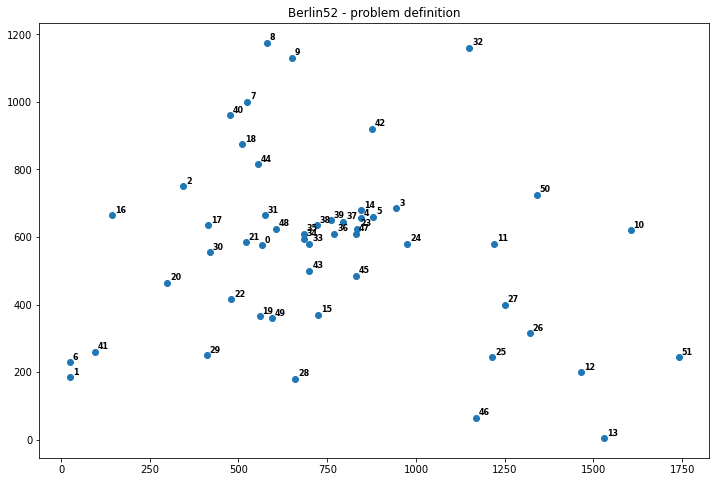

In [17]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

In [8]:
from matplotlib.lines import Line2D


def plot_path(route):
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(coords[:, 0], coords[:, 1], 'o')

    for i in range(n):
        plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

    ax.add_line(Line2D(
        [coords[0, 0], coords[route[0], 0]],
        [coords[0, 1], coords[route[0], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
            (coords[0, 1] + coords[route[0], 1])/2 + 6,
            '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
    for i in range(1, len(route)):
        ax.add_line(Line2D(
            [coords[route[i-1], 0], coords[route[i], 0]],
            [coords[route[i-1], 1], coords[route[i], 1]],
            linewidth=1, color='gray'))
        plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
                (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
                '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
    ax.add_line(Line2D(
        [coords[route[-1], 0], coords[0, 0]],
        [coords[route[-1], 1], coords[0, 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
            (coords[route[-1], 1] + coords[0, 1])/2 + 6,
            '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

    # plt.title('Berlin52 - optimal solution')

    plt.show()

<Figure size 864x576 with 0 Axes>

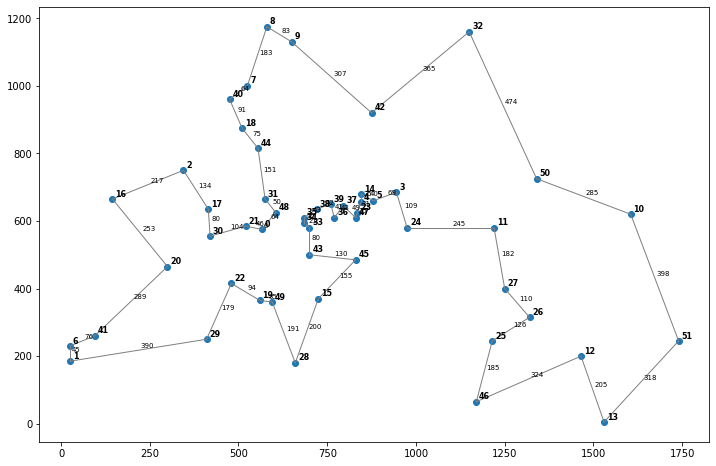

In [9]:
plot_path(berlin52_optimal)

## Objective function

In [6]:
def tsp_objective_function(p, dist=A):
    s = 0.0
    n = len(p)
    for i in range(n):
        s += dist[p[i-1], p[i]]
    return s

In [11]:
print(tsp_objective_function(berlin52_optimal), berlin52_optimal)

7544.365901904086 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## Random Sampling

In [7]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = tsp_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(tsp_objective_function(p), p)

19.22757601737976
21027.254614353224 [13 25  3 24 50 46 28 29 40 39 48 36 37 33  0 11 51 10  1 41 20  2 16 22
 31 35 49  5 47 45 19 17 38 34 42  7 21 44  9 15  4 43 30 23  6 26 27 18
  8 14 32 12]


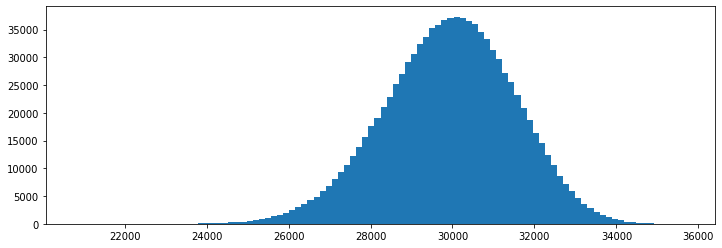

29913.85537071034 1579.5292611495286


In [ ]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
# plt.plot(costs)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [14]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [25]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = tsp_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = tsp_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

16.038990259170532 8887.451884599233


[30977.18889817 30874.59061313 31454.61734217 ...  8887.4518846
  8887.4518846   8887.4518846 ]


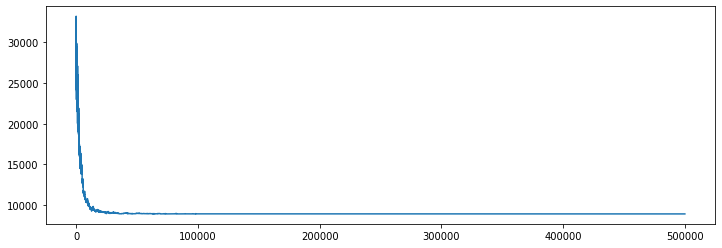

In [26]:
print(costs)
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

## 1a. SGA-PMX

In [9]:
def PMX(ind1, ind2):
    l = len(ind1)

    p = np.random.randint(0,l)
    q = np.random.randint(p, l+1)

    cut1 = ind1[p:q].copy()
    cut2 = ind2[p:q].copy()

    ind1[p:q] = cut2.copy()
    ind2[p:q] = cut1.copy()

    swap1 = dict(zip(cut2, cut1))
    swap2 = dict(zip(cut1, cut2))

    for i in range(l):
        if (not (p <= i < q)):
            while (ind1[i] in swap1):
                ind1[i] = swap1[ind1[i]]

            while (ind2[i] in swap2):
                ind2[i] = swap2[ind2[i]]

    return ind1, ind2

In [10]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [1]:
population_size = 500
chromosome_length = n
number_of_offspring = population_size
crossover_probability = 0.95
mutation_probability = 0.25
number_of_iterations = 250

time0 = time.time()

best_objective_value = np.Inf
best_chromosome = np.zeros((1, chromosome_length))

populations = []

# generating an initial population
current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
for i in range(population_size):
    current_population[i, :] = np.random.permutation(chromosome_length)

# evaluating the objective function on the current population
objective_values = np.zeros(population_size)
for i in range(population_size):
    objective_values[i] = tsp_objective_function(current_population[i, :])

populations_objective_values = []
populations_objective_values.append(objective_values)

for t in range(number_of_iterations):

    # selecting the parent indices by the roulette wheel method
    fitness_values = objective_values.max() - objective_values
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size
    parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

    # creating the children population
    children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
    for i in range(int(number_of_offspring/2)):
        if np.random.random() < crossover_probability:
            children_population[2*i, :], children_population[2*i+1, :] = PMX(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
        else:
            children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
    if np.mod(number_of_offspring, 2) == 1:
        children_population[-1, :] = current_population[parent_indices[-1], :]

    # mutating the children population
    for i in range(number_of_offspring):
        if np.random.random() < mutation_probability:
            children_population[i, :] = reverse_sequence_mutation(children_population[i, :])

    # evaluating the objective function on the children population
    children_objective_values = np.zeros(number_of_offspring)
    for i in range(number_of_offspring):
        children_objective_values[i] = tsp_objective_function(children_population[i, :])

    # replacing the current population by (Mu + Lambda) Replacement
    objective_values = np.hstack([objective_values, children_objective_values])
    current_population = np.vstack([current_population, children_population])

    I = np.argsort(objective_values)
    current_population = current_population[I[:population_size], :]
    objective_values = objective_values[I[:population_size]]

    populations_objective_values.append(objective_values)

    # print(objective_values)

    # recording some statistics
    if best_objective_value > objective_values[0]:
        best_objective_value = objective_values[0]
        best_chromosome = current_population[0, :]

    # print(best_chromosome)

    # print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))

print(best_objective_value, tsp_objective_function(berlin52_optimal))
plot_path(best_chromosome)

NameError: name 'n' is not defined

## 1b
* Optymalne rozwiązanie:   7544.36
* Algorytm ewolucyjny:     8019.11
* Simulated Annealing:     8887.45
* Random sampling:         21361.04

## 1c

In [40]:
def plot_min_max_mean(populations_objective_values):
    ea_means = np.mean(populations_objective_values, axis=1)
    ea_maxs = np.max(populations_objective_values, axis=1)
    ea_mins = np.min(populations_objective_values, axis=1)

    plt.figure(figsize=[12, 7])

    plt.axis(True)
    plt.grid(True)

    plt.plot(ea_means, linewidth=1.5, label="mean")
    plt.plot(ea_mins, linewidth=1.5, label="min")
    plt.plot(ea_maxs, linewidth=1.5, label="max")
    plt.legend()
    plt.show()

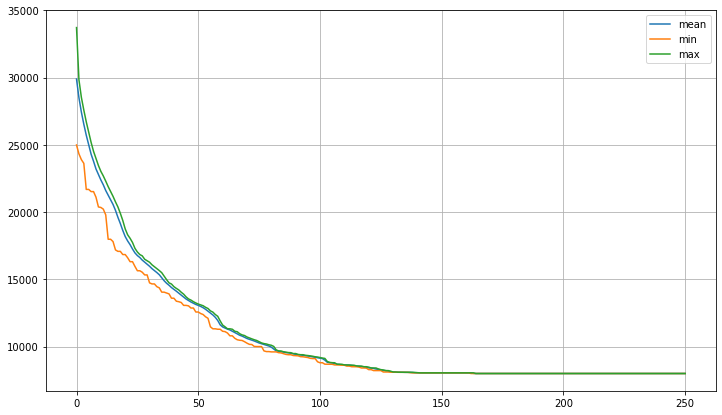

In [41]:
plot_min_max_mean(populations_objective_values)


## 1d

In [21]:
def swap_mutation(p):
    i, j = np.random.choice(n, 2, replace=False)
    q = p.copy()
    q[i], q[j] = q[j], q[i]
    return q

Best value: 11081.447269276909


<Figure size 864x576 with 0 Axes>

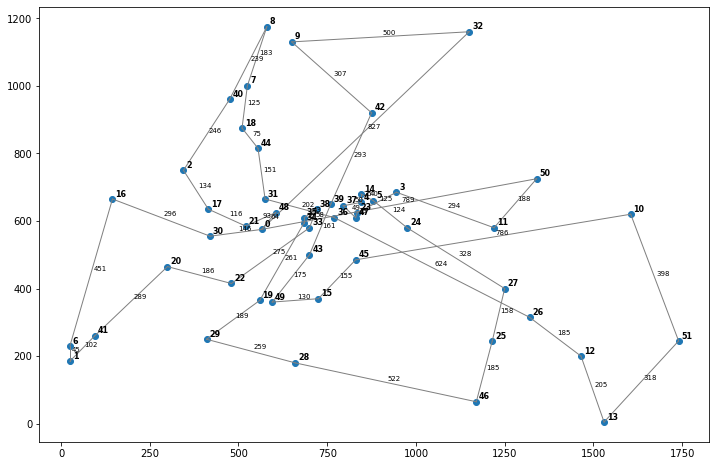

In [23]:
population_size = 500
chromosome_length = n
number_of_offspring = population_size
crossover_probability = 0.95
mutation_probability = 0.25
number_of_iterations = 250

time0 = time.time()

best_objective_value = np.Inf
best_chromosome = np.zeros((1, chromosome_length))

populations = []

# generating an initial population
current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
for i in range(population_size):
    current_population[i, :] = np.random.permutation(chromosome_length)

# evaluating the objective function on the current population
objective_values = np.zeros(population_size)
for i in range(population_size):
    objective_values[i] = tsp_objective_function(current_population[i, :])

populations_objective_values = []
populations_objective_values.append(objective_values)

for t in range(number_of_iterations):

    # selecting the parent indices by the roulette wheel method
    fitness_values = objective_values.max() - objective_values
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size
    parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

    # creating the children population
    children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
    for i in range(int(number_of_offspring/2)):
        if np.random.random() < crossover_probability:
            children_population[2*i, :], children_population[2*i+1, :] = PMX(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
        else:
            children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
    if np.mod(number_of_offspring, 2) == 1:
        children_population[-1, :] = current_population[parent_indices[-1], :]

    # mutating the children population
    for i in range(number_of_offspring):
        if np.random.random() < mutation_probability:
            children_population[i, :] = swap_mutation(children_population[i, :])

    # evaluating the objective function on the children population
    children_objective_values = np.zeros(number_of_offspring)
    for i in range(number_of_offspring):
        children_objective_values[i] = tsp_objective_function(children_population[i, :])

    # replacing the current population by (Mu + Lambda) Replacement
    objective_values = np.hstack([objective_values, children_objective_values])
    current_population = np.vstack([current_population, children_population])

    I = np.argsort(objective_values)
    current_population = current_population[I[:population_size], :]
    objective_values = objective_values[I[:population_size]]

    populations_objective_values.append(objective_values)

    # print(objective_values)

    # recording some statistics
    if best_objective_value > objective_values[0]:
        best_objective_value = objective_values[0]
        best_chromosome = current_population[0, :]

    # print(best_chromosome)

    # print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))

print("Best value: " + str(best_objective_value))
plot_path(best_chromosome)

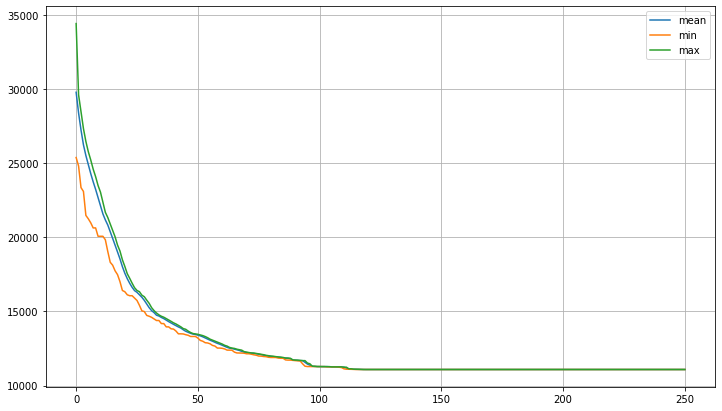

In [24]:
plot_min_max_mean(populations_objective_values)

## 1e
### Dane

In [25]:
def reshape_arr(arr):
    return arr.reshape(int(arr.size/2), 2)

def distance_matrix(coords):
    n = len(coords)
    res = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            res[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())

    return res

In [15]:

bayg29_str = """97 205 139  86  60 220  65 111 115 227  95  82 225 168 103 266 205 149 120  58 257 152  52 180 136  82  34 145
129 103  71 105 258 154 112  65 204 150  87 176 137 142 204 148 148  49  41 211 226 116 197  89 153 124  74
219 125 175 386 269 134 184 313 201 215 267 248 271 274 236 272 160 151 300 350 239 322  78 276 220  60
167 182 180 162 208  39 102 227  60  86  34  96 129  69  58  60 120 119 192 114 110 192 136 173 173
51 296 150  42 131 268  88 131 245 201 175 275 218 202 119  50 281 238 131 244  51 166  95  69
279 114  56 150 278  46 133 266 214 162 302 242 203 146  67 300 205 111 238  98 139  52 120
178 328 206 147 308 172 203 165 121 251 216 122 231 249 209 111 169  72 338 144 237 331
169 151 227 133 104 242 182  84 290 230 146 165 121 270  91  48 158 200  39  64 210
172 309  68 169 286 242 208 315 259 240 160  90 322 260 160 281  57 192 107  90
140 195  51 117  72 104 153  93  88  25  85 152 200 104 139 154 134 149 135
320 146  64  68 143 106  88  81 159 219  63 216 187  88 293 191 258 272
174 311 258 196 347 288 243 192 113 345 222 144 274 124 165  71 153
144  86  57 189 128  71  71  82 176 150  56 114 168  83 115 160
61 165  51  32 105 127 201  36 254 196 136 260 212 258 234
106 110  56  49  91 153  91 197 136  94 225 151 201 205
215 159  64 126 128 190  98  53  78 218  48 127 214
61 155 157 235  47 305 243 186 282 261 300 252
105 100 176  66 253 183 146 231 203 239 204
113 152 127 150 106  52 235 112 179 221
79 163 220 119 164 135 152 153 114
236 201  90 195  90 127  84  91
273 226 148 296 238 291 269
112 130 286  74 155 291
130 178  38  75 180
281 120 205 270
213 145  36
94 217
162
"""



In [16]:
def string_to_array(arr_str: str, n: int):
    arr_str = arr_str.replace("  ", " ")
    arr_str = arr_str.replace("\n ", "\n")

    splited = arr_str.splitlines()

    res = []

    for line in splited:
        row = list(map(int, line.split(" ")))
        row = [0] * (n - len(row)) + row

        res.append(row)

    res.append([0]*n)

    res = np.array(res)

    for i in range(n):
        for j in range(n):
            if (res[i][j] != 0):
                res[j][i] = res[i][j]

    return res

In [17]:
bayg29_opt = np.array([1, 28, 6, 12, 9, 26, 3, 29, 5, 21, 2, 20, 10, 4, 15, 18, 14, 17, 22, 11, 19, 25, 7, 23, 8, 27, 16, 13, 24]) - 1
bayg29_dist = string_to_array(bayg29_str, 29)

In [38]:
bays29_dist =np.array([
[0, 107, 241, 190, 124, 80, 316, 76, 152, 157, 283, 133, 113, 297, 228, 129, 348, 276, 188, 150, 65, 341, 184, 67, 221, 169, 108, 45, 167],
[107, 0, 148, 137, 88, 127, 336, 183, 134, 95, 254, 180, 101, 234, 175, 176, 265, 199, 182, 67, 42, 278, 271, 146, 251, 105, 191, 139, 79],
[241, 148, 0, 374, 171, 259, 509, 317, 217, 232, 491, 312, 280, 391, 412, 349, 422, 356, 355, 204, 182, 435, 417, 292, 424, 116, 337, 273, 77],
[190, 137, 374, 0, 202, 234, 222, 192, 248, 42, 117, 287, 79, 107, 38, 121, 152, 86, 68, 70, 137, 151, 239, 135, 137, 242, 165, 228, 205],
[124, 88, 171, 202, 0, 61, 392, 202, 46, 160, 319, 112, 163, 322, 240, 232, 314, 287, 238, 155, 65, 366, 300, 175, 307, 57, 220, 121, 97],
[80, 127, 259, 234, 61, 0, 386, 141, 72, 167, 351, 55, 157, 331, 272, 226, 362, 296, 232, 164, 85, 375, 249, 147, 301, 118, 188, 60, 185],
[316, 336, 509, 222, 392, 386, 0, 233, 438, 254, 202, 439, 235, 254, 210, 187, 313, 266, 154, 282, 321, 298, 168, 249, 95, 437, 190, 314, 435],
[76, 183, 317, 192, 202, 141, 233, 0, 213, 188, 272, 193, 131, 302, 233, 98, 344, 289, 177, 216, 141, 346, 108, 57, 190, 245, 43, 81, 243],
[152, 134, 217, 248, 46, 72, 438, 213, 0, 206, 365, 89, 209, 368, 286, 278, 360, 333, 284, 201, 111, 412, 321, 221, 353, 72, 266, 132, 111],
[157, 95, 232, 42, 160, 167, 254, 188, 206, 0, 159, 220, 57, 149, 80, 132, 193, 127, 100, 28, 95, 193, 241, 131, 169, 200, 161, 189, 163],
[283, 254, 491, 117, 319, 351, 202, 272, 365, 159, 0, 404, 176, 106, 79, 161, 165, 141, 95, 187, 254, 103, 279, 215, 117, 359, 216, 308, 322],
[133, 180, 312, 287, 112, 55, 439, 193, 89, 220, 404, 0, 210, 384, 325, 279, 415, 349, 285, 217, 138, 428, 310, 200, 354, 169, 241, 112, 238],
[113, 101, 280, 79, 163, 157, 235, 131, 209, 57, 176, 210, 0, 186, 117, 75, 231, 165, 81, 85, 92, 230, 184, 74, 150, 208, 104, 158, 206],
[297, 234, 391, 107, 322, 331, 254, 302, 368, 149, 106, 384, 186, 0, 69, 191, 59, 35, 125, 167, 255, 44, 309, 245, 169, 327, 246, 335, 288],
[228, 175, 412, 38, 240, 272, 210, 233, 286, 80, 79, 325, 117, 69, 0, 122, 122, 56, 56, 108, 175, 113, 240, 176, 125, 280, 177, 266, 243],
[129, 176, 349, 121, 232, 226, 187, 98, 278, 132, 161, 279, 75, 191, 122, 0, 244, 178, 66, 160, 161, 235, 118, 62, 92, 277, 55, 155, 275],
[348, 265, 422, 152, 314, 362, 313, 344, 360, 193, 165, 415, 231, 59, 122, 244, 0, 66, 178, 198, 286, 77, 362, 287, 228, 358, 299, 380, 319],
[276, 199, 356, 86, 287, 296, 266, 289, 333, 127, 141, 349, 165, 35, 56, 178, 66, 0, 112, 132, 220, 79, 296, 232, 181, 292, 233, 314, 253],
[188, 182, 355, 68, 238, 232, 154, 177, 284, 100, 95, 285, 81, 125, 56, 66, 178, 112, 0, 128, 167, 169, 179, 120, 69, 283, 121, 213, 281],
[150, 67, 204, 70, 155, 164, 282, 216, 201, 28, 187, 217, 85, 167, 108, 160, 198, 132, 128, 0, 88, 211, 269, 159, 197, 172, 189, 182, 135],
[65, 42, 182, 137, 65, 85, 321, 141, 111, 95, 254, 138, 92, 255, 175, 161, 286, 220, 167, 88, 0, 299, 229, 104, 236, 110, 149, 97, 108],
[341, 278, 435, 151, 366, 375, 298, 346, 412, 193, 103, 428, 230, 44, 113, 235, 77, 79, 169, 211, 299, 0, 353, 289, 213, 371, 290, 379, 332],
[184, 271, 417, 239, 300, 249, 168, 108, 321, 241, 279, 310, 184, 309, 240, 118, 362, 296, 179, 269, 229, 353, 0, 121, 162, 345, 80, 189, 342],
[67, 146, 292, 135, 175, 147, 249, 57, 221, 131, 215, 200, 74, 245, 176, 62, 287, 232, 120, 159, 104, 289, 121, 0, 154, 220, 41, 93, 218],
[221, 251, 424, 137, 307, 301, 95, 190, 353, 169, 117, 354, 150, 169, 125, 92, 228, 181, 69, 197, 236, 213, 162, 154, 0, 352, 147, 247, 350],
[169, 105, 116, 242, 57, 118, 437, 245, 72, 200, 359, 169, 208, 327, 280, 277, 358, 292, 283, 172, 110, 371, 345, 220, 352, 0, 265, 178, 39],
[108, 191, 337, 165, 220, 188, 190, 43, 266, 161, 216, 241, 104, 246, 177, 55, 299, 233, 121, 189, 149, 290, 80, 41, 147, 265, 0, 124, 263],
[45, 139, 273, 228, 121, 60, 314, 81, 132, 189, 308, 112, 158, 335, 266, 155, 380, 314, 213, 182, 97, 379, 189, 93, 247, 178, 124, 0, 199],
[167, 79, 77, 205, 97, 185, 435, 243, 111, 163, 322, 238, 206, 288, 243, 275, 319, 253, 281, 135, 108, 332, 342, 218, 350, 39, 263, 199, 0],
])
bays29_opt = np.array([1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13, 21]) -1

In [29]:
kroA100 = [1380, 939, 2848, 96, 3510, 1671, 457, 334, 3888, 666, 984, 965, 2721, 1482, 1286, 525, 2716, 1432, 738, 1325, 1251, 1832, 2728, 1698, 3815, 169, 3683, 1533, 1247, 1945, 123, 862, 1234, 1946, 252, 1240, 611, 673, 2576, 1676, 928, 1700, 53, 857, 1807, 1711, 274, 1420, 2574, 946, 178, 24, 2678, 1825, 1795, 962, 3384, 1498, 3520, 1079, 1256, 61, 1424, 1728, 3913, 192, 3085, 1528, 2573, 1969, 463, 1670, 3875, 598, 298, 1513, 3479, 821, 2542, 236, 3955, 1743, 1323, 280, 3447, 1830, 2936, 337, 1621, 1830, 3373, 1646, 1393, 1368, 3874, 1318, 938, 955, 3022, 474, 2482, 1183, 3854, 923, 376, 825, 2519, 135, 2945, 1622, 953, 268, 2628, 1479, 2097, 981, 890, 1846, 2139, 1806, 2421, 1007, 2290, 1810, 1115, 1052, 2588, 302, 327, 265, 241, 341, 1917, 687, 2991, 792, 2573, 599, 19, 674, 3911, 1673, 872, 1559, 2863, 558, 929, 1766, 839, 620, 3893, 102, 2178, 1619, 3822, 899, 378, 1048, 1178, 100, 2599, 901, 3416, 143, 2961, 1605, 611, 1384, 3113, 885, 2597, 1830, 2586, 1286, 161, 906, 1429, 134, 742, 1025, 1625, 1651, 1187, 706, 1787, 1009, 22, 987, 3640, 43, 3756, 882, 776, 392, 1724, 1642, 198, 1810, 3950, 1558]
kroA100 = reshape_arr(np.array(kroA100))

kroA100_dist = distance_matrix(kroA100)

kroA100_opt = np.array([1, 47, 93, 28, 67, 58, 61, 51, 87, 25, 81, 69, 64, 40, 54, 2, 44, 50, 73, 68, 85, 82, 95, 13, 76, 33, 37, 5, 52, 78, 96, 39, 30, 48, 100, 41, 71, 14, 3, 43, 46, 29, 34, 83, 55, 7, 9, 57, 20, 12, 27, 86, 35, 62, 60, 77, 23, 98, 91, 45, 32, 11, 15, 17, 59, 74, 21, 72, 10, 84, 36, 99, 38, 24, 18, 79, 53, 88, 16, 94, 22, 70, 66, 26, 65, 4, 97, 56, 80, 31, 89, 42, 8, 92, 75, 19, 90, 49, 6, 63]) - 1

In [40]:
kroA150 = [1380, 939, 2848, 96, 3510, 1671, 457, 334, 3888, 666, 984, 965, 2721, 1482, 1286, 525, 2716, 1432, 738, 1325, 1251, 1832, 2728, 1698, 3815, 169, 3683, 1533, 1247, 1945, 123, 862, 1234, 1946, 252, 1240, 611, 673, 2576, 1676, 928, 1700, 53, 857, 1807, 1711, 274, 1420, 2574, 946, 178, 24, 2678, 1825, 1795, 962, 3384, 1498, 3520, 1079, 1256, 61, 1424, 1728, 3913, 192, 3085, 1528, 2573, 1969, 463, 1670, 3875, 598, 298, 1513, 3479, 821, 2542, 236, 3955, 1743, 1323, 280, 3447, 1830, 2936, 337, 1621, 1830, 3373, 1646, 1393, 1368, 3874, 1318, 938, 955, 3022, 474, 2482, 1183, 3854, 923, 376, 825, 2519, 135, 2945, 1622, 953, 268, 2628, 1479, 2097, 981, 890, 1846, 2139, 1806, 2421, 1007, 2290, 1810, 1115, 1052, 2588, 302, 327, 265, 241, 341, 1917, 687, 2991, 792, 2573, 599, 19, 674, 3911, 1673, 872, 1559, 2863, 558, 929, 1766, 839, 620, 3893, 102, 2178, 1619, 3822, 899, 378, 1048, 1178, 100, 2599, 901, 3416, 143, 2961, 1605, 611, 1384, 3113, 885, 2597, 1830, 2586, 1286, 161, 906, 1429, 134, 742, 1025, 1625, 1651, 1187, 706, 1787, 1009, 22, 987, 3640, 43, 3756, 882, 776, 392, 1724, 1642, 198, 1810, 3950, 1558, 3477, 949, 91, 1732, 3972, 329, 198, 1632, 1806, 733, 538, 1023, 3430, 1088, 2186, 766, 1513, 1646, 2143, 1611, 53, 1657, 3404, 1307, 1034, 1344, 2823, 376, 3104, 1931, 3232, 324, 2790, 1457, 374, 9, 741, 146, 3083, 1938, 3502, 1067, 1280, 237, 3326, 1846, 217, 38, 2503, 1172, 3527, 41, 739, 1850, 3548, 1999, 48, 154, 1419, 872, 1689, 1223, 3468, 1404, 1628, 253, 382, 872, 3029, 1242, 3646, 1758, 285, 1029, 1782, 93, 1067, 371, 2849, 1214, 920, 1835, 1741, 712, 876, 220, 2753, 283, 2609, 1286, 3941, 258, 3613, 523, 1754, 559, 2916, 1724, 2445, 1820]

kroA150 = reshape_arr(np.array(kroA150))

kroA150_dist = distance_matrix(kroA150)

In [41]:
kroA200 = [1357, 1905, 2650, 802, 1774, 107, 1307, 964, 3806, 746, 2687, 1353, 43, 1957, 3092, 1668, 185, 1542, 834, 629, 40, 462, 1183, 1391, 2048, 1628, 1097, 643, 1838, 1732, 234, 1118, 3314, 1881, 737, 1285, 779, 777, 2312, 1949, 2576, 189, 3078, 1541, 2781, 478, 705, 1812, 3409, 1917, 323, 1714, 1660, 1556, 3729, 1188, 693, 1383, 2361, 640, 2433, 1538, 554, 1825, 913, 317, 3586, 1909, 2636, 727, 1000, 457, 482, 1337, 3704, 1082, 3635, 1174, 1362, 1526, 2049, 417, 2552, 1909, 3939, 640, 219, 898, 812, 351, 901, 1552, 2513, 1572, 242, 584, 826, 1226, 3278, 799, 86, 1065, 14, 454, 1327, 1893, 2773, 1286, 2469, 1838, 3835, 963, 1031, 428, 3853, 1712, 1868, 197, 1544, 863, 457, 1607, 3174, 1064, 192, 1004, 2318, 1925, 2232, 1374, 396, 828, 2365, 1649, 2499, 658, 1410, 307, 2990, 214, 3646, 1018, 3394, 1028, 1779, 90, 1058, 372, 2933, 1459, 3099, 173, 2178, 978, 138, 1610, 2082, 1753, 2302, 1127, 805, 272, 22, 1617, 3213, 1085, 99, 536, 1533, 1780, 3564, 676, 29, 6, 3808, 1375, 2221, 291, 3499, 1885, 3124, 408, 781, 671, 1027, 1041, 3249, 378, 3297, 491, 213, 220, 721, 186, 3736, 1542, 868, 731, 960, 303, 1380, 939, 2848, 96, 3510, 1671, 457, 334, 3888, 666, 984, 965, 2721, 1482, 1286, 525, 2716, 1432, 738, 1325, 1251, 1832, 2728, 1698, 3815, 169, 3683, 1533, 1247, 1945, 123, 862, 1234, 1946, 252, 1240, 611, 673, 2576, 1676, 928, 1700, 53, 857, 1807, 1711, 274, 1420, 2574, 946, 178, 24, 2678, 1825, 1795, 962, 3384, 1498, 3520, 1079, 1256, 61, 1424, 1728, 3913, 192, 3085, 1528, 2573, 1969, 463, 1670, 3875, 598, 298, 1513, 3479, 821, 2542, 236, 3955, 1743, 1323, 280, 3447, 1830, 2936, 337, 1621, 1830, 3373, 1646, 1393, 1368, 3874, 1318, 938, 955, 3022, 474, 2482, 1183, 3854, 923, 376, 825, 2519, 135, 2945, 1622, 953, 268, 2628, 1479, 2097, 981, 890, 1846, 2139, 1806, 2421, 1007, 2290, 1810, 1115, 1052, 2588, 302, 327, 265, 241, 341, 1917, 687, 2991, 792, 2573, 599, 19, 674, 3911, 1673, 872, 1559, 2863, 558, 929, 1766, 839, 620, 3893, 102, 2178, 1619, 3822, 899, 378, 1048, 1178, 100, 2599, 901, 3416, 143, 2961, 1605, 611, 1384, 3113, 885, 2597, 1830, 2586, 1286, 161, 906, 1429, 134, 742, 1025, 1625, 1651, 1187, 706, 1787, 1009, 22, 987, 3640, 43, 3756, 882, 776, 392, 1724, 1642, 198, 1810, 3950, 1558]

kroA200 = reshape_arr(np.array(kroA200))
kroA200_dist = distance_matrix(kroA200)

In [11]:
def evolution(population_size=500, chromosome_length=0, crossover_probability=0.95, number_of_offspring=500,
    mutation_probability=0.25, number_of_iterations=250, crossover=PMX, mutation=reverse_sequence_mutation, dist=None, mutation2=None):
    time0 = time.time()

    chromosome_length=len(dist)

    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    populations = []

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :], dist)

    populations_objective_values = []
    populations_objective_values.append(objective_values)

    for t in tqdm(range(number_of_iterations)):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = crossover(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation(children_population[i, :])

            if mutation2 != None:
                children_population[i, :] = mutation2(children_population[i,:], dist)

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :], dist)

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        populations_objective_values.append(objective_values)

        # print(objective_values)

        # recording some statistics
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        # print(best_chromosome)

        # print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))

    print(f"Best value: {str(best_objective_value)}")
    print(f"Best chromosome:  {str(best_chromosome)}")
    # plot_path(best_chromosome)

    return populations_objective_values

### Wyniki

100%|██████████| 100/100 [00:01<00:00, 73.85it/s]


Best value: 1644.0
Best chromosome:  [19  9  3 14 17 13 16 21 10 18 24  6 22 15 12 23 26  7  0 27 11  5 20  4
  8 25  2 28  1]
[ 0 27  5 11  8 25  2 28  4 20  1 19  9  3 14 17 13 16 21 10 18 24  6 22
  7 26 15 12 23] 1610.0


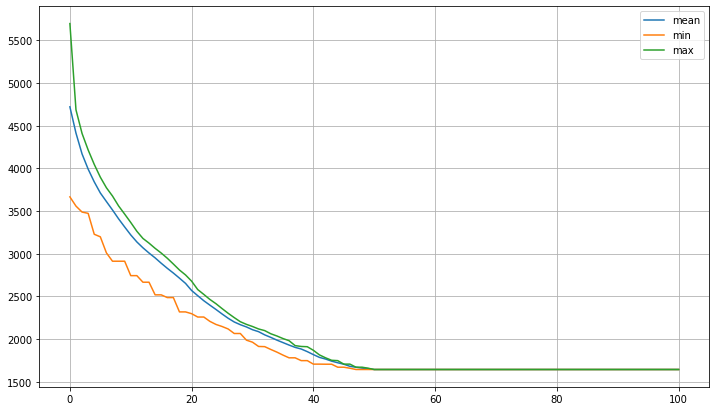

In [65]:
bayg29_res = evolution(dist=bayg29_dist, chromosome_length=29, number_of_iterations=100, population_size=500)
print(bayg29_opt, tsp_objective_function(bayg29_opt, bayg29_dist))

plot_min_max_mean(bayg29_res)

100%|██████████| 250/250 [00:03<00:00, 72.67it/s]

Best value: 2052.0
Best chromosome:  [23  7 26 22  6 24 18 14 10 21 13 16 17  3  9 19  1  2 28 25  4  8 11  5
 27  0 20 12 15]
[ 0 27  5 11  8  4 25 28  2  1 19  9  3 14 17 16 13 21 10 18 24  6 22 26
  7 23 15 12 20] 2020.0


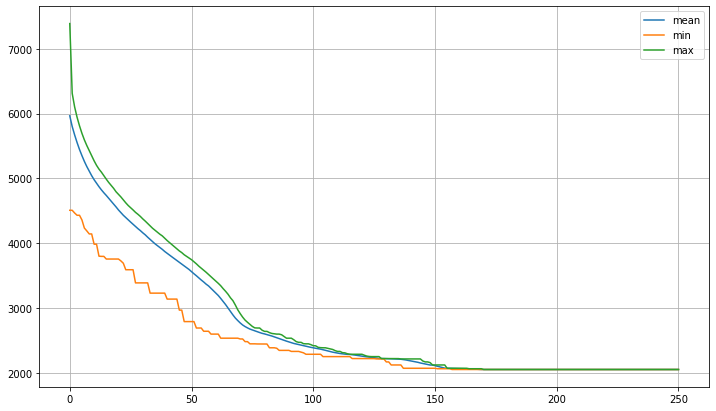

In [66]:
bays29_res = evolution(dist=bays29_dist, chromosome_length=29, number_of_iterations=250, population_size=2000)
print(bays29_opt, tsp_objective_function(bays29_opt, bays29_dist))

plot_min_max_mean(bays29_res)

100%|██████████| 2000/2000 [00:56<00:00, 35.33it/s]


Best value: 23678.538929262322
Best chromosome:  [74 18  3 64 25 65 69 21 15 87 93 17 23 37 98 35 20 73 58 16 14 10 31 44
 22 97 90 46 62 71  9 83 78 52 89 48  5 91  7  0 92 27 66 57 76 59 61 19
 85 34 26 11 54 82 33 28 45 42  2 13 70 40 99 47 29 38 95 77 51  4 36 32
 75 12 94 81 43 49 72 67 84  8  6 56 86 50 60 24 80 68 63 39  1 53 88 41
 30 79 55 96]
[ 0 46 92 27 66 57 60 50 86 24 80 68 63 39 53  1 43 49 72 67 84 81 94 12
 75 32 36  4 51 77 95 38 29 47 99 40 70 13  2 42 45 28 33 82 54  6  8 56
 19 11 26 85 34 61 59 76 22 97 90 44 31 10 14 16 58 73 20 71  9 83 35 98
 37 23 17 78 52 87 15 93 21 69 65 25 64  3 96 55 79 30 88 41  7 91 74 18
 89 48  5 62] 21285.44318157108


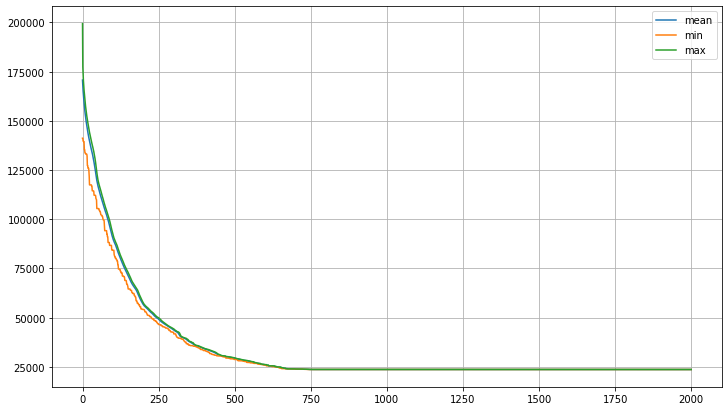

In [67]:
kroA100_res = evolution(dist=kroA100_dist, chromosome_length=100, number_of_iterations=2000, population_size=2000)
print(kroA100_opt, tsp_objective_function(kroA100_opt, kroA100_dist))

plot_min_max_mean(kroA100_res)

100%|██████████| 1000/1000 [00:40<00:00, 24.60it/s]


Best value: 31678.634280696417
Best chromosome:  [ 19  26  85  34 149  61  59 109  76 144 139  60  24  80  68 107  66 104
 147 141 129  62  48   5 112  71  20  73  10  14  16 140  58 126  35 110
 101  98 103  37  23  83   9  89 105  18  52 133  87 136  78  17  93  15
  21  69  65 128 117  25 123  64   3  74  96 118 142  55 138  79  30  41
 121  88 132 137   7  91   0  27  57  92 130  46 108  31  44  90  22  97
  50 124  86   8  56   6 116  33 134  84  67  72  49  43 143 113  63  39
  53   1 115  81 125  94  12  75  32 102 145  36   4  77  51  95 146  38
 100 120 106  29  47  13  99  70  40 127 135   2 131 111  28  45  42 122
 114 119 148  82  54  11]


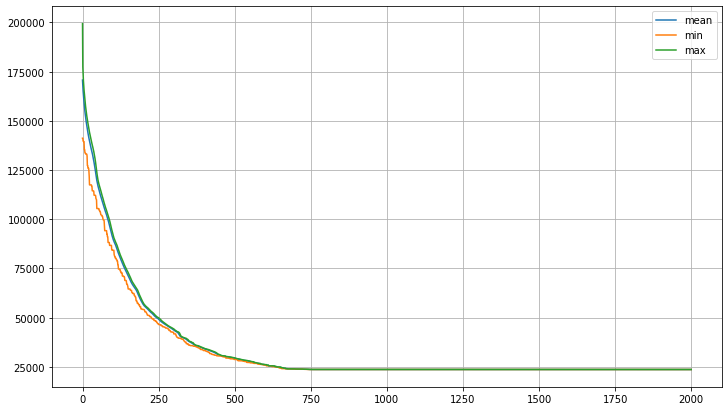

In [69]:
kroA150_res = evolution(dist=kroA150_dist, chromosome_length=150, number_of_iterations=1000, population_size=2000)

plot_min_max_mean(kroA100_res)

# Brak optymalnego rozwiązania w bazie

100%|██████████| 3000/3000 [02:32<00:00, 19.67it/s]


33289.102136259346
[198  31  23 171  45 120 173 158 116 114 110  52   0 131  84 144 190  26
 197 122  14  12 176  78 159  19  63 161  66  64  30  46 119 185  54  41
 134 126 111 156 106  74 154 182  21 133   7  16  24 142  89  33  57 140
 170 199 147  87  97 113 102 145 128  82  61  53 108   5 186 150  79 160
 124 180   1  34  67 168 163 139 143  22 172 149  90  93  94 167 184  49
 138  71 129  38  27  37  70  55 151 177 195   4 104  42 136  85 112 132
 175 194 181  75  69 101  20 153  88  40 166  29  76 157 127 192 146  39
  11  48 148 105  92 162   3 100  59 191  13  98  18  91   9 174 107 141
  68  58   2  72 188 130 179  73  56  35  99 155  32  44 196  80  96 103
 164 125  86  95 165  51  10  83  47 152  65 118 189  17 109  28 183  36
 178  62  43 187 115 169 121 193  50  15 117 123   8 137  60 135  25  77
  81   6]


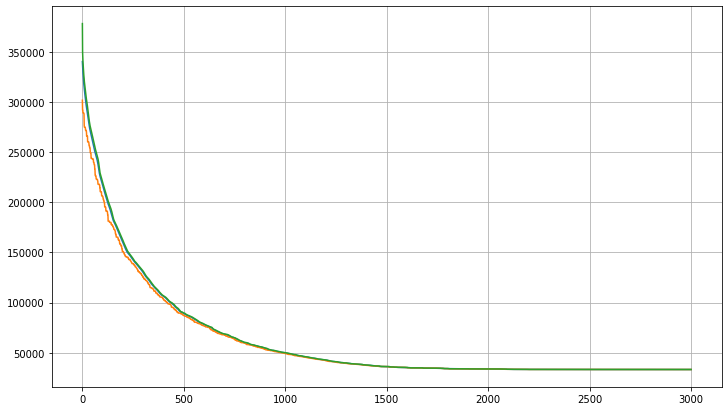

In [ ]:
kroA200_res = evolution(dist=kroA200_dist, chromosome_length=200, number_of_iterations=3000, population_size=2000)

plot_min_max_mean(kroA200_res)

# Brak optymalnego rozwiązania w bazie

## Zadanie 2

### Cycle crossover

In [27]:
# cycle crossover
def CX(ind1, ind2):
    n = len(ind1)
    
    map1 = [-1]*n
    map2 = [-1]*n

    for i in range(n):
        map1[ind1[i]] = i
        map2[ind2[i]] = i

    off1 = np.zeros(n) - 1
    off2 = np.zeros(n) - 1

    def cycle_from(i):
        off1[i] = ind1[i]
        off2[i] = ind2[i]

        j = map1[ind2[i]]

        while j != i:
            off1[j] = ind1[j]
            off2[j] = ind2[j]

            j = map1[ind2[j]]


    for i in range(n):
        if (off1[i] == -1):
            cycle_from(i)
            ind1, ind2 = ind2, ind1
            map1, map2 = map2, map1



    return off1, off2



100%|██████████| 2000/2000 [01:28<00:00, 22.65it/s]


Best value: 24065.901342235287
Best chromosome:  [25 65 69 21 93 15 87 52 89 78 17 23 37 98 35 83  9 71 20 73 58 16 14 10
 31 44 22 59 61 34 85 26 11 19 76 97 90 46 62  0 92 27 66 57 50 86 56  8
  6 54 82 33 28 45 42  2 13 70 40 99 47 51 77 29 38 95  4 36 32 75 12 94
 81 43 49 72 67 84 80 24 60 68 63 39  1 53 88 30 79 55 96 41  7 91  5 48
 74 18  3 64]
[ 0 46 92 27 66 57 60 50 86 24 80 68 63 39 53  1 43 49 72 67 84 81 94 12
 75 32 36  4 51 77 95 38 29 47 99 40 70 13  2 42 45 28 33 82 54  6  8 56
 19 11 26 85 34 61 59 76 22 97 90 44 31 10 14 16 58 73 20 71  9 83 35 98
 37 23 17 78 52 87 15 93 21 69 65 25 64  3 96 55 79 30 88 41  7 91 74 18
 89 48  5 62] 21285.44318157108


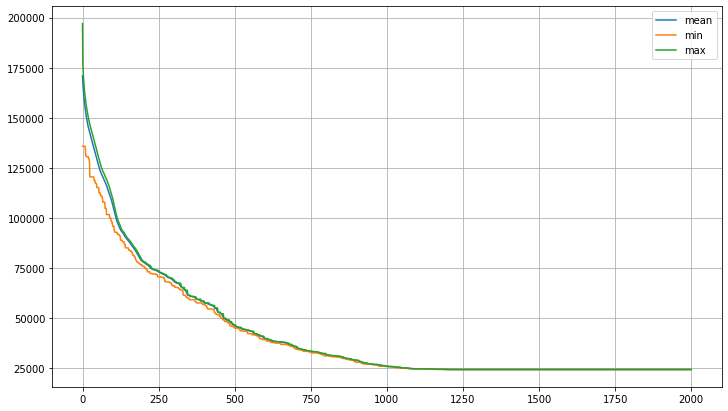

In [30]:
kroA100_res = evolution(dist=kroA100_dist, chromosome_length=100, number_of_iterations=2000, population_size=2000, crossover=CX)
print(kroA100_opt, tsp_objective_function(kroA100_opt, kroA100_dist))

plot_min_max_mean(kroA100_res)

### Order-1 crossover

In [40]:
#order_1 crossover
@jit(nopython=True)
def OX(ind1, ind2):
    n = len(ind1)

    p = np.random.randint(0,n)
    q = np.random.randint(p+1, n+1)

    def offspring(par1, par2):
        res = np.zeros(n)-1
        cut = par1[p:q]
        res[p:q] = cut
        cut_set = set(cut)
        i = q%n
        for val in np.concatenate((par2[q:], par2[:q])):
            if val not in cut_set:
                res[i] = val
                i = (i+1)%n        

        return res

    return offspring(ind1, ind2), offspring(ind2, ind1)

100%|██████████| 2000/2000 [01:06<00:00, 30.18it/s]


22767.39862627541
[52 78 87 15 93 21 69 65 25 64  3 96 55 79 30 88 41  7 66 27 92  0 91  5
 62 46 90 97 22 76 19 56  6  8 86 50 57 60 24 80 68 63 39 53  1 43 49 72
 67 84 29 38 81 94 12 75 32 36  4 95 77 51 47 99 40 70 13  2 42 45 28 33
 82 54 11 26 85 34 61 59 44 31 10 14 16 58 73 20 71 35 98 37 23 17 83  9
 89 48 74 18]
[ 0 46 92 27 66 57 60 50 86 24 80 68 63 39 53  1 43 49 72 67 84 81 94 12
 75 32 36  4 51 77 95 38 29 47 99 40 70 13  2 42 45 28 33 82 54  6  8 56
 19 11 26 85 34 61 59 76 22 97 90 44 31 10 14 16 58 73 20 71  9 83 35 98
 37 23 17 78 52 87 15 93 21 69 65 25 64  3 96 55 79 30 88 41  7 91 74 18
 89 48  5 62] 21285.44318157108


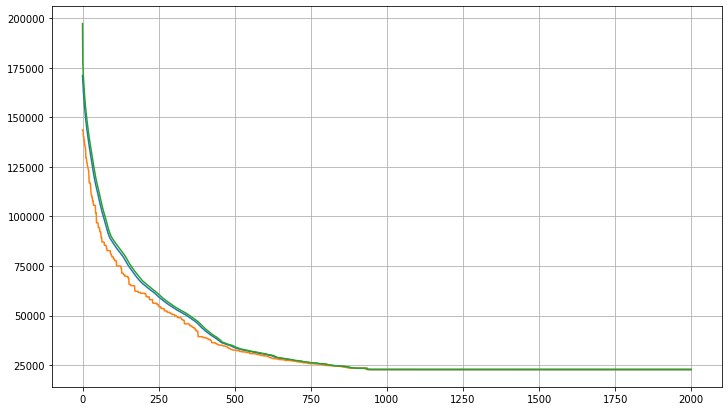

In [41]:
kroA100_res = evolution(dist=kroA100_dist, chromosome_length=100, number_of_iterations=2000, population_size=2000, crossover=OX)
print(kroA100_opt, tsp_objective_function(kroA100_opt, kroA100_dist))

plot_min_max_mean(kroA100_res)

### Position-based crossover

In [20]:
def PBX(ind1, ind2):
    n = len(ind1)
    prob = np.random.random()
    positions = list(filter((lambda _: np.random.random() < prob), range(n)))
    positions.sort()


    def offspring(par1, par2):
        res = np.zeros(n)-1
        cut = par1[positions]
        res[positions] = cut
        cut_set = set(cut)
        i = 0

        to_fill = list(filter((lambda x: not (x in positions)), range(n)))

        for val in par2:
            if val not in cut_set:
                res[to_fill[i]] = val
                i += 1     

        return res


    result = offspring(ind1, ind2), offspring(ind2, ind1)

    return result


100%|██████████| 1500/1500 [01:17<00:00, 19.25it/s]


Best value: 23707.120857243972
Best chromosome:  [ 3 64 25 65 69 52 78 87 15 21 93 17 23 37 98 35 83 89  9 71 20 73 58 16
 14 10 31 44 22 59 61 34 85 26 11 54 82 33 28 45 42  2 13 70 40 99 47 51
 77  4 36 95 29 38 84 67 72 49 43 81 12 32 75 94  1 53 39 63 68 80 24 60
 66 27 92 57 50 86  8  6 56 19 76 97 90 46  0  7 41 88 30 79 55 91 62  5
 48 18 74 96]
[ 0 46 92 27 66 57 60 50 86 24 80 68 63 39 53  1 43 49 72 67 84 81 94 12
 75 32 36  4 51 77 95 38 29 47 99 40 70 13  2 42 45 28 33 82 54  6  8 56
 19 11 26 85 34 61 59 76 22 97 90 44 31 10 14 16 58 73 20 71  9 83 35 98
 37 23 17 78 52 87 15 93 21 69 65 25 64  3 96 55 79 30 88 41  7 91 74 18
 89 48  5 62] 21285.44318157108


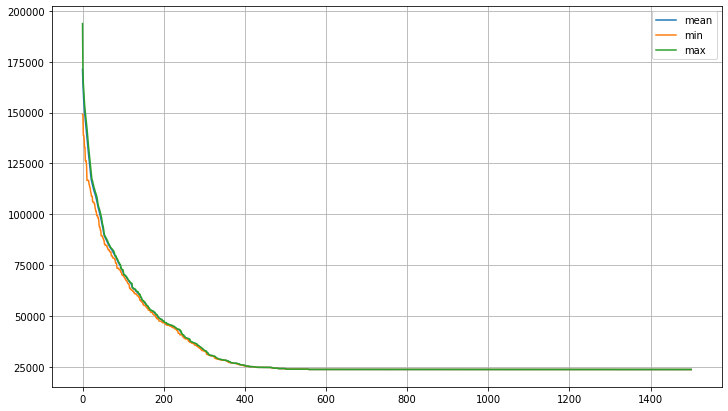

In [71]:
kroA100_res = evolution(dist=kroA100_dist, chromosome_length=100, number_of_iterations=1500, population_size=500, crossover=PBX)
print(kroA100_opt, tsp_objective_function(kroA100_opt, kroA100_dist))

plot_min_max_mean(kroA100_res)

## Zadanie 3

In [57]:
# @jit(nopython=True)
def perms_in_range(perm, k):
    n = len(perm)
    combinations = list(it.combinations(range(n), k))

    comb_count = len(combinations)
    perm_count = len(list(it.permutations(range(k)))) - 1

    size = comb_count * perm_count + 1

    res = np.repeat([perm], size, axis=0)
    

    for i,comb in enumerate(combinations):
        perm_c = list(it.permutations(comb))
        
        base = perm_c[0]
        changes = perm_c[1:]
        
        for j,change in enumerate(changes):
            res[i*perm_count+j+1][np.array(base)] = perm[np.array(change)]

    return res

# @jit(nopython=True)
def best_perm_in_range(k):
    def best_perm_in_k(perm, dist):
        perms = perms_in_range(perm, k)
        number_of_perms = len(perms)
        objective_values = np.zeros(number_of_perms)

        for i in range(number_of_perms):
            objective_values[i] = tsp_objective_function(perms[i], dist)

        best_index = np.argmin(objective_values)

        return perms[best_index]

    return best_perm_in_k
    

def best_perm_2(k, perm, dist):
    perms = perms_in_range(perm, k)
    number_of_perms = len(perms)
    objective_values = np.zeros(number_of_perms)

    for i in range(number_of_perms):
        objective_values[i] = tsp_objective_function(perms[i], dist)

    best_index = np.argmin(objective_values)

    return perms[best_index]

# @jit(nopython=True)
def best_perm_rec(k, n):
    def best_perm_in_k_rec(perm, dist):
        best = perm
        current = perm

        for _ in range(n):
            current = best_perm_2(k, current, dist)
            if (np.array_equal(current, best)):
                return best
            best = current

        return best

    return best_perm_in_k_rec
    

100%|██████████| 50/50 [02:40<00:00,  3.20s/it]

Best value: 1648.0
Best chromosome:  [24 10 21 16 13 17 14  3  9 19  1 20  4 28  2 25  8 11  5 27  0  7 23 12
 18 15 26 22  6]
[ 0 27  5 11  8 25  2 28  4 20  1 19  9  3 14 17 13 16 21 10 18 24  6 22
  7 26 15 12 23] 1610.0


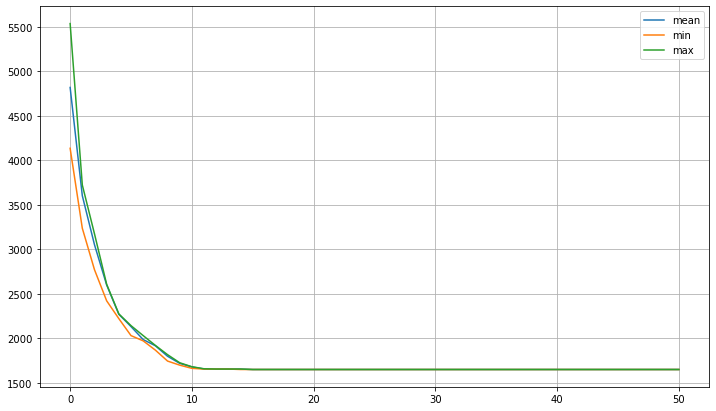

In [43]:
bayg29_res = evolution(dist=bayg29_dist, chromosome_length=29, number_of_iterations=50, population_size=50, crossover=PBX, mutation2=best_perm_in_range(2))
print(bayg29_opt, tsp_objective_function(bayg29_opt, bayg29_dist))

plot_min_max_mean(bayg29_res)

100%|██████████| 50/50 [04:33<00:00,  5.46s/it]

Best value: 1643.0
Best chromosome:  [13 16 21 10 18 24  6 22 26  7 27  5 11  8  4 25  2 28  1 20  0 23 15 12
 19  9  3 14 17]
[ 0 27  5 11  8 25  2 28  4 20  1 19  9  3 14 17 13 16 21 10 18 24  6 22
  7 26 15 12 23] 1610.0


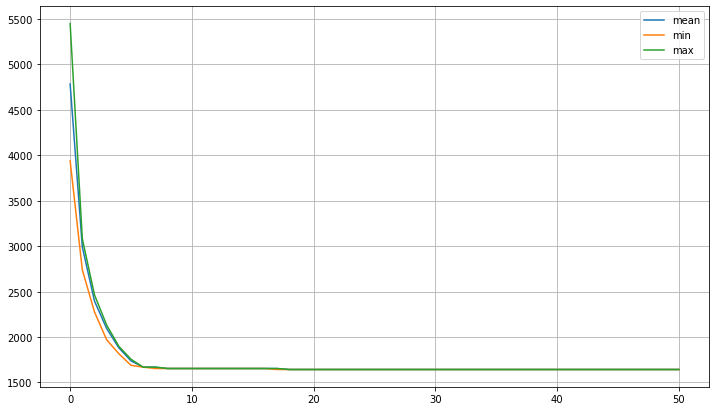

In [58]:
bayg29_res = evolution(dist=bayg29_dist, chromosome_length=29, number_of_iterations=50, population_size=50, crossover=PBX, mutation2=best_perm_rec(2, 3))
print(bayg29_opt, tsp_objective_function(bayg29_opt, bayg29_dist))

plot_min_max_mean(bayg29_res)